# Security & Artificial Intelligence Project

## Authors :

* Alexandre Lemonnier
* Sarah Gutierez
* Victor Simonin

## Project objectives

The goal of the project is to design, deploy and evaluate a data chain for the analysis of
cybersecurity data. The data treatment will be performed as batch.

We chose Objective 1 :
   - Anomaly detection for tracking attacks
   
Our dataset :
   - The UGR’16 Dataset
   
Data date :
   - June - Week 1, Date range: 01/06/2016 - 05/06/2016

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sb
import numpy as np
import matplotlib.lines as mlines
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## Capture data
Here we import our train dataset from the first week of June.

In [2]:
col_names = ["Date", "Duration", "Source_IP", "Destination_IP", "Source_Port",
             "Destination_Port", "Protocol", "Flag", "Forwarding_Status", "Service_Type", "Packets", "Bytes", "Label"]

In [3]:
data_june = pd.read_csv('data/train/june.week1.csv', names=col_names, nrows=1000000)
data_june

,Date,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Forwarding_Status,Service_Type,Packets,Bytes,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016-06-01 00:15:20,0.636,42.219.156.182,253.139.127.225,51944,25,TCP,.APRS.,0,0,6,355,background
999996,2016-06-01 00:15:20,0.636,42.219.156.182,253.139.127.225,58625,25,TCP,.APRS.,0,0,6,355,background
999997,2016-06-01 00:15:20,0.636,42.219.156.182,253.139.127.227,36784,25,TCP,.APRS.,0,0,6,355,background
999998,2016-06-01 00:15:20,0.636,42.219.156.182,253.139.127.227,39940,25,TCP,.APRS.,0,0,7,395,background


In [4]:
genuine_repartition = 0.96
attack_repartition = 0.04
train_data_size = 10000

Let's build our train dataset with **96%** of genuine netflow and **4%** of attack.

In [5]:
df_genuine = data_june[data_june['Label'] == 'background'].head(int(train_data_size * genuine_repartition)).copy()
df_attacks = data_june[data_june['Label'] != 'background'].head(int(train_data_size * attack_repartition)).copy()
train_df = pd.concat([df_genuine, df_attacks])
train_df

,Date,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Forwarding_Status,Service_Type,Packets,Bytes,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236466,2016-06-01 00:07:38,0.000,42.219.158.188,143.72.8.137,25469,53,UDP,.A....,0,0,1,54,blacklist
236467,2016-06-01 00:07:38,0.000,42.219.158.188,143.72.8.137,33316,53,UDP,.A....,0,0,1,76,blacklist
236468,2016-06-01 00:07:38,0.000,42.219.158.188,143.72.8.137,36503,53,UDP,.A....,0,0,1,76,blacklist
236469,2016-06-01 00:07:38,0.000,42.219.158.188,143.72.8.137,37345,53,UDP,.A....,0,0,1,67,blacklist


Here we import our test dataset from the fifth week of July.

In [6]:
data_july = pd.read_csv('data/test/july.week5.csv', names=col_names, nrows=1000000)
data_july

,Date,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Forwarding_Status,Service_Type,Packets,Bytes,Label
0,2016-07-27 13:43:21,48.380,187.96.221.207,42.219.153.7,53,53,UDP,.A....,0,0,2,209,background
1,2016-07-27 13:43:21,48.380,42.219.153.7,187.96.221.207,53,53,UDP,.A....,0,0,2,167,background
2,2016-07-27 13:43:25,50.632,42.219.153.191,62.205.150.146,80,1838,TCP,.AP...,0,0,9,2082,background
3,2016-07-27 13:43:25,51.052,62.205.150.146,42.219.153.191,1838,80,TCP,.AP...,0,0,9,7118,background
4,2016-07-27 13:43:27,46.996,92.225.28.133,42.219.155.111,443,59867,TCP,.AP...,0,0,4,674,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2016-07-27 13:52:59,16.928,42.219.153.89,104.235.226.45,52418,443,TCP,.AP.SF,0,0,6,816,background
999996,2016-07-27 13:52:59,16.932,42.219.153.89,104.235.226.45,52419,443,TCP,.AP.SF,0,0,6,816,background
999997,2016-07-27 13:52:59,1.704,42.219.154.121,192.22.7.102,38718,25,TCP,.AP.SF,0,0,3305,4711799,background
999998,2016-07-27 13:52:59,1.708,42.219.154.123,194.233.64.116,80,52656,TCP,.AP.S.,0,0,74,100883,background


In [7]:
test_data_size = 10000
test_df = data_july.head(test_data_size).copy()
test_df

,Date,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Forwarding_Status,Service_Type,Packets,Bytes,Label
0,2016-07-27 13:43:21,48.380,187.96.221.207,42.219.153.7,53,53,UDP,.A....,0,0,2,209,background
1,2016-07-27 13:43:21,48.380,42.219.153.7,187.96.221.207,53,53,UDP,.A....,0,0,2,167,background
2,2016-07-27 13:43:25,50.632,42.219.153.191,62.205.150.146,80,1838,TCP,.AP...,0,0,9,2082,background
3,2016-07-27 13:43:25,51.052,62.205.150.146,42.219.153.191,1838,80,TCP,.AP...,0,0,9,7118,background
4,2016-07-27 13:43:27,46.996,92.225.28.133,42.219.155.111,443,59867,TCP,.AP...,0,0,4,674,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2016-07-27 13:43:40,0.096,36.76.99.47,42.219.158.160,49565,80,TCP,.AP.SF,0,64,5,987,background
9996,2016-07-27 13:43:40,0.096,42.219.158.160,36.76.99.47,80,49565,TCP,.AP.SF,0,0,6,3993,background
9997,2016-07-27 13:43:40,0.100,117.71.181.33,42.219.159.86,80,51125,TCP,.A..SF,0,0,2,1445,background
9998,2016-07-27 13:43:40,0.100,36.76.99.47,42.219.158.160,21362,80,TCP,.AP.SF,0,64,6,1027,background


We stock the dataframes in the `data` list to apply the same cleaning:

In [8]:
data = { "train" : train_df, "test": test_df}

## General overview

In [9]:
data["train"].info()
print('_'*40)
data["test"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 236470
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               10000 non-null  object 
 1   Duration           10000 non-null  float64
 2   Source_IP          10000 non-null  object 
 3   Destination_IP     10000 non-null  object 
 4   Source_Port        10000 non-null  int64  
 5   Destination_Port   10000 non-null  int64  
 6   Protocol           10000 non-null  object 
 7   Flag               10000 non-null  object 
 8   Forwarding_Status  10000 non-null  int64  
 9   Service_Type       10000 non-null  int64  
 10  Packets            10000 non-null  int64  
 11  Bytes              10000 non-null  int64  
 12  Label              10000 non-null  object 
dtypes: float64(1), int64(6), object(6)
memory usage: 1.1+ MB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 

**Which features are categorical?**

These values classify the samples into sets of similar samples. 

- **Categorical**: Date, Source_IP, Destination_IP, Source_Port, Destination_Port, Protocol, Flag, Label.

*Source_Port* and *Destination_Port* are of **int64** type, so we will have to categorize them. 

**Which features are numerical?**

These values change from sample to sample.

- **Numerical**: Duration, Forwarding Status, Type of Service, Packets, Bytes

In [10]:
for _, df in data.items():
    df['Source_Port'] = df['Source_Port'].astype(object)
    df['Destination_Port'] = df['Destination_Port'].astype(object)

In [11]:
cat_col = list(train_df.select_dtypes(include=object).columns.values)
cat_col

['Date',
 'Source_IP',
 'Destination_IP',
 'Source_Port',
 'Destination_Port',
 'Protocol',
 'Flag',
 'Label']

In [12]:
num_col = list(train_df._get_numeric_data().columns.values)
num_col

['Duration', 'Forwarding_Status', 'Service_Type', 'Packets', 'Bytes']

**Which features may contain errors or typos?**

We know that data come from a consistent netflow so they should be quite accurate.

**Which features contain blank, null or empty values?**

We can observe that dataframes do not contain any null value.

In [13]:
data["train"].isna().sum()

Date                 0
Duration             0
Source_IP            0
Destination_IP       0
Source_Port          0
Destination_Port     0
Protocol             0
Flag                 0
Forwarding_Status    0
Service_Type         0
Packets              0
Bytes                0
Label                0
dtype: int64

## Data analysis




Let's get statistics about the numerical data:

In [14]:
data["train"].describe()

,Duration,Forwarding_Status,Service_Type,Packets,Bytes
count,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04
mean,1.267133,0.0,1.967500,17.802200,1.305524e+04
std,6.917004,0.0,12.731742,784.207307,9.818564e+05
min,0.000000,0.0,0.000000,1.000000,2.900000e+01
25%,0.000000,0.0,0.000000,1.000000,8.600000e+01
50%,0.148000,0.0,0.000000,3.000000,2.255000e+02
75%,0.789000,0.0,0.000000,7.000000,9.350000e+02
max,261.412000,0.0,208.000000,68650.000000,9.814513e+07


There is not numerical data with a negative value. That's a good point because all expected to be strictly positive.

However, we observe that `Forwarding_Status` column is full of zeroes. We decide to drop it.

In [15]:
for _, df in data.items():
    df.drop(columns='Forwarding_Status', inplace=True)
data["train"].head()

,Date,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Service_Type,Packets,Bytes,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,2,175,background


Let's get statistics about the categorical data:

In [16]:
train_df.describe(include=['O'])

,Date,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Label
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,103,1704,2830,4435,4775,4,19,2
top,2016-06-01 00:05:16,42.219.156.211,42.219.156.211,53,53,TCP,.A....,background
freq,1182,1161,940,1947,1447,6415,3859,9600


We can see that Ips and Ports are not all unique and appears multiple times in the dataset.  

## Preprocessing data

In [17]:
data["train"]['Label'].unique()

array(['background', 'blacklist'], dtype=object)

Let's numerize `Label` column with `0` value is the netflow is normal and `1` otherwise.

In [18]:
for _, df in data.items():
    df['Label'] = np.where(df['Label'] == 'background', 0, 1)
print("Train dataset \'Label\' unique value:", data["train"]['Label'].unique())
print("Test dataset \'Label\' unique value:", data["test"]['Label'].unique())

Train dataset 'Label' unique value: [0 1]
Test dataset 'Label' unique value: [0 1]


Let's divide `Date` column in multiple attributes, to analyse which one is relevant with the `Label` value.

In [19]:
for _, df in data.items():
    df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S")
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['week'] = df['Date'].dt.isocalendar().week
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second
    df['dayOfWeek'] = df['Date'].dt.dayofweek
    df.drop(columns='Date', inplace=True)

Dataframes should look like that now:

In [20]:
data["train"].head()

,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Service_Type,Packets,Bytes,Label,year,month,day,week,hour,minute,second,dayOfWeek
0,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,19,3958,0,2016,6,1,22,0,5,1,2
1,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,57,79635,0,2016,6,1,22,0,5,3,2
2,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,9,2791,0,2016,6,1,22,0,5,4,2
3,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,13,3896,0,2016,6,1,22,0,5,4,2
4,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,2,175,0,2016,6,1,22,0,5,4,2


In [21]:
corr = data["train"].corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/lib/python3.10/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Duration,Service_Type,Packets,Bytes,Label,year,month,day,week,hour,minute,second,dayOfWeek
Duration,1.000000,-0.018325,0.512220,0.383358,0.066698,nan,nan,nan,nan,nan,0.044027,0.000970,nan
Service_Type,-0.018325,1.000000,-0.002071,-0.001800,0.076680,nan,nan,nan,nan,nan,0.078836,0.036927,nan
Packets,0.512220,-0.002071,1.000000,0.883493,-0.002526,nan,nan,nan,nan,nan,-0.001886,-0.014319,nan
Bytes,0.383358,-0.001800,0.883493,1.000000,-0.001875,nan,nan,nan,nan,nan,-0.001505,-0.010885,nan
Label,0.066698,0.076680,-0.002526,-0.001875,1.000000,nan,nan,nan,nan,nan,0.827848,0.397177,nan
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
month,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
day,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
week,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hour,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


We can observe that we have a lot of NaN corresponding to the different attribute of the date.  
Our data are based on the same `year`,`month` and `week` so we can drop these columns, they will not be relevant.  
In our batch of data, `day` is not relevant at all because we are only focusing on one week.

In [22]:
for _, df in data.items():
    df.drop(columns=['year', 'month', 'week', 'day'], inplace=True)

### Feature engineering

Moreover, we decide to replace `hour`, `minute`, `second` column with a delta from the beginning of the day.

In [23]:
for _, df in data.items():
    df['timeDelta'] = df['hour'] *3600 + df['minute'] * 60 + df['second']
    df.drop(columns=['hour', 'minute', 'second'], inplace=True)
data['train']

,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Service_Type,Packets,Bytes,Label,dayOfWeek,timeDelta
0,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,19,3958,0,2,301
1,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,57,79635,0,2,303
2,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,9,2791,0,2,304
3,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,13,3896,0,2,304
4,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,2,175,0,2,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236466,0.000,42.219.158.188,143.72.8.137,25469,53,UDP,.A....,0,1,54,1,2,458
236467,0.000,42.219.158.188,143.72.8.137,33316,53,UDP,.A....,0,1,76,1,2,458
236468,0.000,42.219.158.188,143.72.8.137,36503,53,UDP,.A....,0,1,76,1,2,458
236469,0.000,42.219.158.188,143.72.8.137,37345,53,UDP,.A....,0,1,67,1,2,458


In [24]:
data["train"][["Source_IP", "Label"]].groupby(["Source_IP"],as_index=False).mean().sort_values(by='Label', ascending=False).head()

,Source_IP,Label
1292,50.33.218.194,1.0
839,222.11.231.252,1.0
695,213.30.31.179,1.0
836,221.17.125.37,1.0
1293,50.33.218.239,1.0


In [25]:
data["train"][["Destination_IP", "Label"]].groupby(['Destination_IP'],as_index=False).mean().sort_values(by='Label', ascending=False).head()

,Destination_IP,Label
2103,51.210.95.1,1.0
835,204.97.46.104,1.0
1147,213.30.31.179,1.0
2523,71.161.145.125,1.0
2522,71.161.116.194,1.0


In [26]:
data["train"][["Source_Port", "Label"]].groupby(['Source_Port'],as_index=False).mean().sort_values(by='Label', ascending=False).head()

,Source_Port,Label
3615,56920,1.0
1774,41416,1.0
2643,49678,1.0
1290,36503,1.0
2649,49747,1.0


In [27]:
data["train"][["Destination_Port", "Label"]].groupby(['Destination_Port'],as_index=False).mean().sort_values(by='Label', ascending=False).head()

,Destination_Port,Label
973,31308,1.0
802,25469,1.0
1400,37563,1.0
1100,33892,1.0
788,25089,1.0


In [28]:
data["train"][["Protocol", "Label"]].groupby(['Protocol'],as_index=False).mean().sort_values(by='Label', ascending=False)

,Protocol,Label
3,UDP,0.042237
2,TCP,0.039283
0,ESP,0.000000
1,ICMP,0.000000


In [29]:
data["train"][["Flag", "Label"]].groupby(['Flag'],as_index=False).mean().sort_values(by='Label', ascending=False)

,Flag,Label
4,.A...F,0.257732
9,.A.RS.,0.181818
16,.APR.F,0.142857
7,.A.R..,0.120690
17,.APRS.,0.100000
13,.AP.S.,0.094456
11,.AP...,0.072727
6,.A..SF,0.065657
3,.A....,0.040425
2,...R..,0.030675


In [30]:
data["train"][["Service_Type", "Label"]].groupby(['Service_Type'],as_index=False).mean().sort_values(by='Label', ascending=False)

,Service_Type,Label
8,28,1.000000
13,72,0.397059
10,40,0.168539
1,2,0.117647
0,0,0.034931
2,8,0.024390
11,64,0.000000
16,200,0.000000
15,192,0.000000
14,184,0.000000


We can observe that for `Source_IP`, `Destination_IP`, `Source_Port` and `Destination_Port` column data is relevant for finding attacks because some IP and Port are only used for this type of netflow.

We will have to transform our categorical data in numerical data to use them in our classification model.  
We will use a **One Hot Encoder** transformer to numerize our categorical data.  

## Graphical analysis

In [31]:
def show3D_netflow_data(netflow_dataset, x_axis_name, y_axis_name, z_axis_name, only_error):
    X = netflow_dataset.drop(columns=['Label'])
    Y = netflow_dataset['Label']
    
    x = x_axis_name
    y = y_axis_name
    z = z_axis_name

    limit = len(X)

    sb.reset_orig()

    fig = plt.figure(figsize = (10, 12))
    
    ax = fig.add_subplot(111, projection='3d')
    if not only_error:
        ax.scatter(np.log10(X.loc[Y == 0, x][:limit]),
                   (X.loc[Y == 0, y][:limit] + 0.1),
                   -np.log10(X.loc[Y == 0, z][:limit] + 0.1),
                   c = 'g',
                   marker = '.',
                   s = 1,
                   label = 'genuine')
    
    ax.scatter(np.log10(X.loc[Y == 1, x][:limit]),
               (X.loc[Y == 1, y][:limit] + 0.1),
               -np.log10(X.loc[Y == 1, z][:limit] + 0.1),
               c = 'r',
               marker = '.',
               s = 1,
               label = 'attack')
    
    ax.set_xlabel(x, size = 16)
    ax.set_ylabel(y + ' [hour]', size = 16)
    ax.set_zlabel('-log10(' + z + ')', size = 16)
    ax.set_title('Error-based features separate out genuine and attack netflow', size = 20)
    
    plt.axis('tight')
    ax.grid(1)
    
    noFraudMarker = mlines.Line2D([],
                                  [],
                                  linewidth = 0,
                                  color = 'g',
                                  marker = '.',
                                  markersize = 10,
                                  label = 'genuine')
    
    fraudMarker = mlines.Line2D([],
                                [],
                                linewidth = 0,
                                color = 'r',
                                marker = '.',
                                markersize = 10,
                                label = 'attack')
    
    plt.legend(handles = [noFraudMarker, fraudMarker],
               bbox_to_anchor = (1.20, 0.38),
               frameon = False,
               prop = {'size': 16})

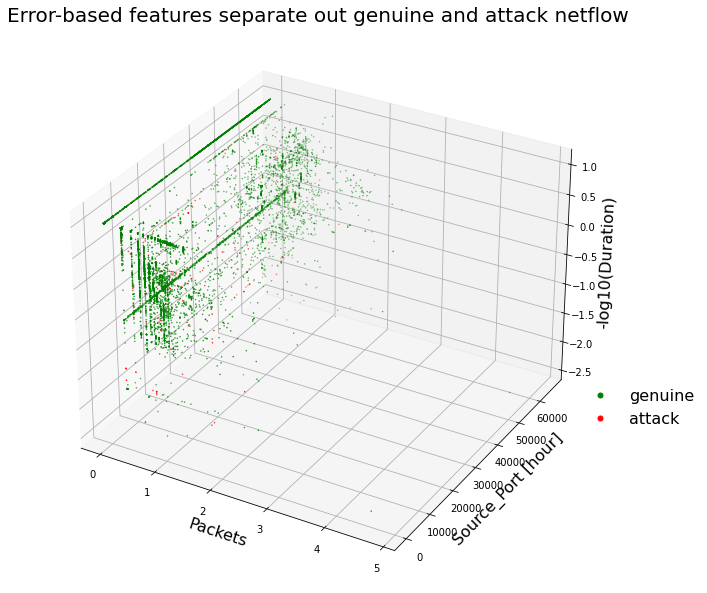

In [32]:
show3D_netflow_data(data["train"], 'Packets', 'Source_Port', 'Duration', False)

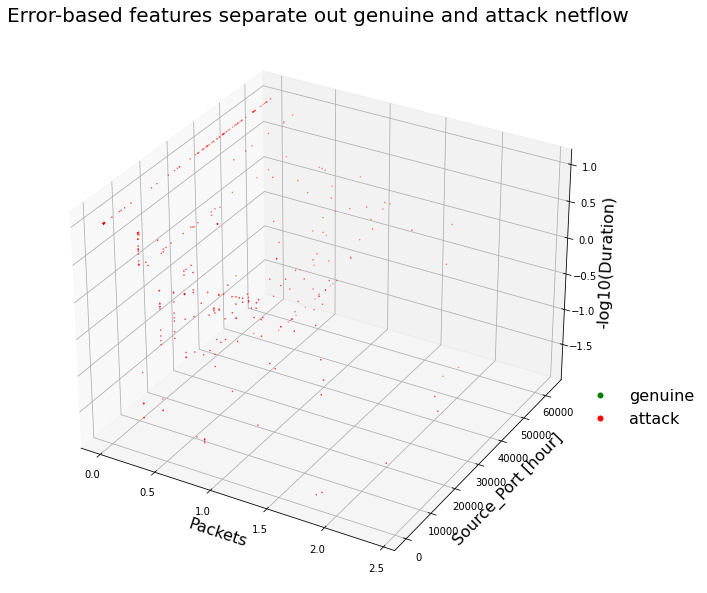

In [33]:
show3D_netflow_data(data["train"], 'Packets', 'Source_Port' , 'Duration', True)

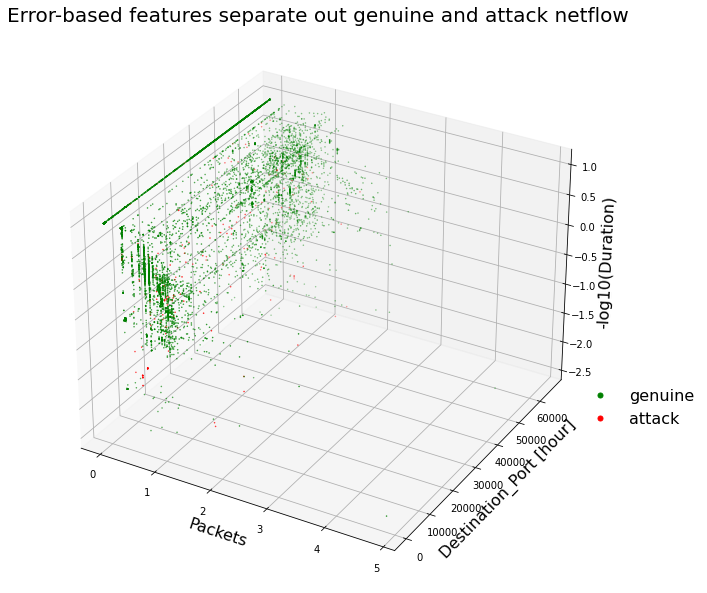

In [34]:
show3D_netflow_data(data["train"], 'Packets', 'Destination_Port' , 'Duration', False)

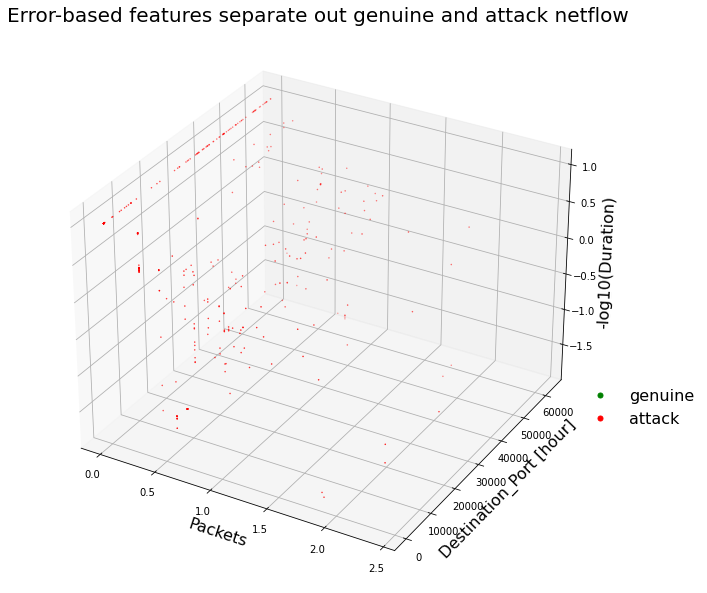

In [35]:
show3D_netflow_data(data["train"], 'Packets', 'Destination_Port' , 'Duration', True)

We can observe that `Source_Port` and `Destination_Port` are relevant to find if a netflow is genuine or not. 

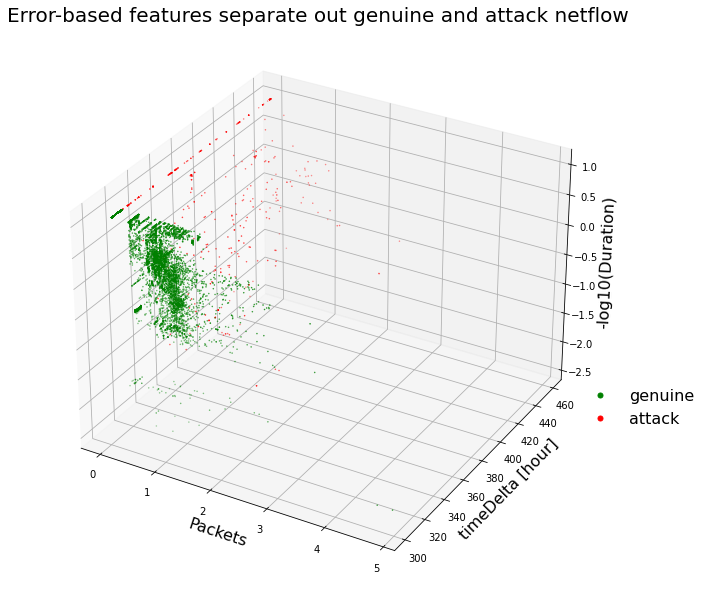

In [36]:
show3D_netflow_data(data["train"], 'Packets', 'timeDelta', 'Duration', False)

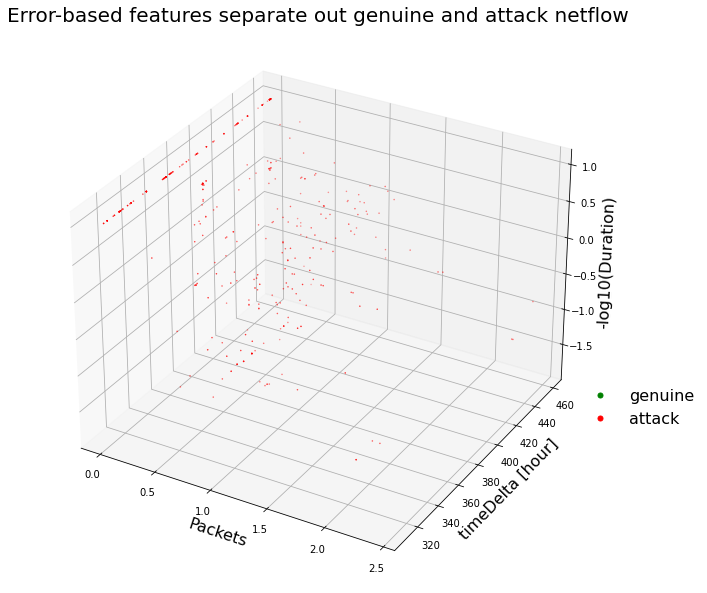

In [37]:
show3D_netflow_data(data["train"], 'Packets', 'timeDelta', 'Duration', True)

## Supervised machine learning model benchmarking

In [53]:
import xgboost as xgb
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, mean_squared_error, average_precision_score

In [39]:
cat_col = ['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port', 'Protocol', 'Flag', 'Service_Type', 'dayOfWeek']
cat_col

['Source_IP',
 'Destination_IP',
 'Source_Port',
 'Destination_Port',
 'Protocol',
 'Flag',
 'Service_Type',
 'dayOfWeek']

In [40]:
num_col = ['Duration', 'Packets', 'Bytes', 'timeDelta']
num_col

['Duration', 'Packets', 'Bytes', 'timeDelta']

In [41]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_col))

In [42]:
X_train = data["train"].drop(columns=['Label'])
Y_train = data["train"]['Label'].copy()

In [43]:
X_test = data["test"].drop(columns=["Label"])
Y_test = data["test"]['Label'].copy()

Let's benchmark some model with their default parameters 

In [44]:
classifier_score = {}

In [45]:
def classifier_testing(classifier):
    print(f"Testing {classifier[0]}...")
    pipeline = Pipeline([
        ('transformer', transformer),
        ('classifier', classifier[1]),
    ])
    print("Fitting...")
    pipeline.fit(X_train, Y_train)
    print("Predicting...")
    y_pred = pipeline.predict(X_test)
    print("Scoring...")
    score = f1_score(Y_test, y_pred)
    print(f"{classifier[0]} score : {score}")
    classifier_score[classifier[0]] = score

In [46]:
classifiers = {
    "SVC": SVC(),
    "LinearSVC": LinearSVC(),
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "Perceptron" : Perceptron(),
    "SGD" : SGDClassifier(),
    "DecisionTree" : DecisionTreeClassifier()
}

In [47]:
for key, value in classifiers.items():
    classifier_testing((key, value))

Testing SVC...
Fitting...
Predicting...
Scoring...
SVC score : 0.8688524590163933
Testing LinearSVC...
Fitting...
Predicting...
Scoring...
LinearSVC score : 0.864
Testing LogisticRegression...
Fitting...
Predicting...
Scoring...
LogisticRegression score : 0.8688524590163933
Testing RandomForest...
Fitting...
Predicting...
Scoring...
RandomForest score : 0.8760330578512396
Testing Perceptron...
Fitting...
Predicting...
Scoring...
Perceptron score : 0.8688524590163933
Testing SGD...
Fitting...
Predicting...
Scoring...
SGD score : 0.84375
Testing DecisionTree...
Fitting...
Predicting...
Scoring...
DecisionTree score : 0.8709677419354839


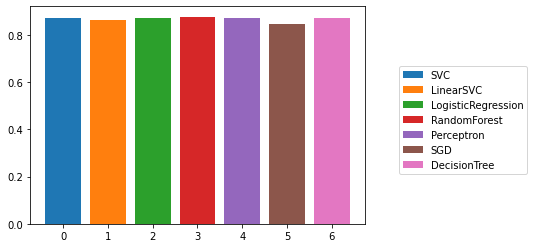

In [48]:
for i, test in enumerate(classifier_score.items()):
    plt.bar(i, test[1], label=test[0])
plt.legend(bbox_to_anchor=(1, 0.25, 0.5, 0.5))

In [54]:
trainX, testX, trainY, testY = train_test_split(data["train"].drop(columns='Label').copy(), data["train"]['Label'].copy(), test_size=0.2, random_state=42)

weights = (trainY == 0).sum() / (1.0 * (trainY == 1).sum())
xgb_model = xgb.XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4, random_state=42)
pipeline = Pipeline([
        ('transformer', transformer),
        ('classifier', xgb_model),
    ])

proba = pipeline.fit(trainX, trainY).predict_proba(testX)

auprc = average_precision_score(testY, proba[:, 1]) 
print(f"Xgboost score: {auprc}")

Xgboost score: 0.9601196179638286


In [52]:
weights = (Y_train == 0).sum() / (1.0 * (Y_train == 1).sum())
xgb_model = xgb.XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4, random_state=42)
pipeline = Pipeline([
        ('transformer', transformer),
        ('classifier', xgb_model),
    ])

proba = pipeline.fit(X_train, Y_train).predict_proba(X_test)

auprc = average_precision_score(Y_test, proba[:, 1]) 
print(f"Xgboost score: {auprc}")

Xgboost score: 0.8122848219566245


In [96]:
pipeline = Pipeline([
        ('transformer', transformer),
        ('classifier', RandomForestClassifier(max_depth=500)),
    ])
print("Fitting...")
pipeline.fit(X_train, Y_train)
print("Predicting...")
y_pred = pipeline.predict(X_test)
print("Scoring...")
score = f1_score(Y_test, y_pred)
print(f"DecisionTree score : {score}")
y_score = pipeline.predict_proba(X_test)[:, 1]

Fitting...
Predicting...
Scoring...
DecisionTree score : 0.25316455696202533


In [ ]:
dT_results = X_test.copy()
dT_results["is_attack"] = y_pred == -1

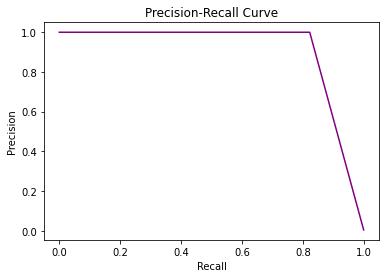

In [ ]:
precision, recall, thresholds = precision_recall_curve(Y_test, y_score)
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

## Unsurpervised machine learning model
### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('classifier', IsolationForest(contamination=0.03, random_state=42))
    ]
)

In [ ]:
%time pipeline.fit(data["train"])

CPU times: user 7min 43s, sys: 13.1 s, total: 7min 56s
Wall time: 8min 4s


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Source_IP',
                                                   'Destination_IP',
                                                   'Source_Port',
                                                   'Destination_Port',
                                                   'Protocol', 'Flag',
                                                   'Service_Type',
                                                   'dayOfWeek'])])),
                ('classifier',
                 IsolationForest(contamination=0.03, random_state=42))])

In [ ]:
if_attack = pipeline.predict(data["train"])

In [ ]:
if_results = data["train"].copy()
if_results["if_attack"] = if_attack == -1

In [ ]:
nb_attacks = len(data["train"][data["train"].Label == 1])
nb_genuine = len(data["train"][data["train"].Label == 0])
print("True positive : ", len(if_results[(if_results["Label"] == 1) & (if_results["if_attack"] == True)]), "/", nb_attacks)
print("False positive :" , len(if_results[(if_results["Label"] == 0) & (if_results["if_attack"] == True)]), "/", nb_genuine)
print("True negative :" , len(if_results[(if_results["Label"] == 0) & (if_results["if_attack"] == False)]), "/", nb_genuine)
print("False negative :" , len(if_results[(if_results["Label"] == 1) & (if_results["if_attack"] == False)]), "/", nb_attacks)

True positive :  513 / 30000
False positive : 29475 / 970000
True negative : 29487 / 30000
False negative : 940525 / 970000


In [ ]:
if_results.groupby(by=['if_attack', 'Label']).count()

Duration  Source_IP  Destination_IP  Source_Port  \
if_attack Label                                                     
False     0        940525     940525          940525       940525   
          1         29487      29487           29487        29487   
True      0         29475      29475           29475        29475   
          1           513        513             513          513   

                 Destination_Port  Protocol    Flag  Service_Type  Packets  \
if_attack Label                                                              
False     0                940525    940525  940525        940525   940525   
          1                 29487     29487   29487         29487    29487   
True      0                 29475     29475   29475         29475    29475   
          1                   513       513     513           513      513   

                  Bytes  dayOfWeek  timeDelta  
if_attack Label                                
False     0      940525     940525     940525  
          1       29487      29487      29487  
True      0       29475      29475      29475  
          1         513        513        513

In [ ]:
def show3D_netflow_if_attack_only(transac_dataset, x_axis_name, y_axis_name, z_axis_name):
    X = transac_dataset.drop(columns=['if_attack'])
    Y = transac_dataset['if_attack']
    x = x_axis_name
    y = y_axis_name
    z = z_axis_name
    limit = len(X)
    sb.reset_orig()
    fig = plt.figure(figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X.loc[Y == 1, x][:limit],
               X.loc[Y == 1, y][:limit],
               -np.log10(X.loc[Y == 1, z][:limit]),
               c = 'r',
               marker = '.', 
               s = 1, 
               label = 'if_attack')
    
    ax.set_xlabel(x, size = 16)
    ax.set_ylabel(y + ' [hour]', size = 16)
    ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
    ax.set_title('Features separate for attacks netflow', size = 20)
    
    plt.axis('tight')
    ax.grid(1)
    
    fraudMarker = mlines.Line2D([], [], linewidth = 0, color = 'r', marker = '.', markersize = 10, label = 'if_attack')
    
    plt.legend(handles= [fraudMarker], bbox_to_anchor = (1.20, 0.38), frameon = False, prop = {'size': 16})

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


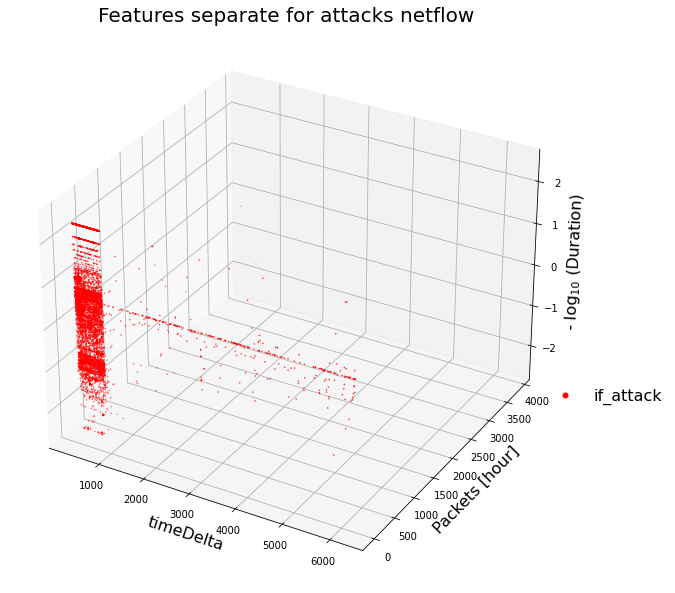

In [ ]:
show3D_netflow_if_attack_only(if_results, 'timeDelta', 'Packets', 'Duration')

### Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('classifier', LocalOutlierFactor(contamination=0.03))
    ]
)
lof_attack = pipeline.fit_predict(data["train"])

In [ ]:
lof_results = data["train"].copy()
lof_results["lof_attack"] = lof_attack == -1

In [ ]:
nb_attacks = len(data["train"][data["train"].Label == 1])
nb_genuine = len(data["train"][data["train"].Label == 0])
print("True positive : ", len(lof_results[(lof_results["Label"] == 1) & (lof_results["lof_attack"] == True)]), "/", nb_attacks)
print("False positive :" , len(lof_results[(lof_results["Label"] == 0) & (lof_results["lof_attack"] == True)]), "/", nb_genuine)
print("True negative :" , len(lof_results[(lof_results["Label"] == 1) & (lof_results["lof_attack"] == False)]), "/", nb_attacks)
print("False negative :" , len(lof_results[(lof_results["Label"] == 0) & (lof_results["lof_attack"] == False)]), "/", nb_genuine)

True positive :  12 / 400
False positive : 290 / 9700
True negative : 388 / 400
False negative : 9410 / 9700


In [ ]:
lof_results.groupby(by=['lof_attack', 'Label']).count()

Duration  Source_IP  Destination_IP  Source_Port  \
lof_attack Label                                                     
False      0          9410       9410            9410         9410   
           1           388        388             388          388   
True       0           290        290             290          290   
           1            12         12              12           12   

                  Destination_Port  Protocol  Flag  Service_Type  Packets  \
lof_attack Label                                                            
False      0                  9410      9410  9410          9410     9410   
           1                   388       388   388           388      388   
True       0                   290       290   290           290      290   
           1                    12        12    12            12       12   

                  Bytes  dayOfWeek  timeDelta  
lof_attack Label                               
False      0       9410       9410       9410  
           1        388        388        388  
True       0        290        290        290  
           1         12         12         12

In [ ]:
def show3D_netflow_lof_attack_only(transac_dataset, x_axis_name, y_axis_name, z_axis_name):
    X = transac_dataset.drop(columns=['lof_attack'])
    Y = transac_dataset['lof_attack']
    x = x_axis_name
    y = y_axis_name
    z = z_axis_name
    limit = len(X)
    sb.reset_orig()
    fig = plt.figure(figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X.loc[Y == 1, x][:limit],
               X.loc[Y == 1, y][:limit],
               -np.log10(X.loc[Y == 1, z][:limit]),
               c = 'r',
               marker = '.', 
               s = 1, 
               label = 'lof_attack')
    
    ax.set_xlabel(x, size = 16)
    ax.set_ylabel(y + ' [hour]', size = 16)
    ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
    ax.set_title('Features separate for attacks netflow', size = 20)
    
    plt.axis('tight')
    ax.grid(1)
    
    fraudMarker = mlines.Line2D([], [], linewidth = 0, color = 'r', marker = '.', markersize = 10, label = 'lof_attack')
    
    plt.legend(handles= [fraudMarker], bbox_to_anchor = (1.20, 0.38), frameon = False, prop = {'size': 16})

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


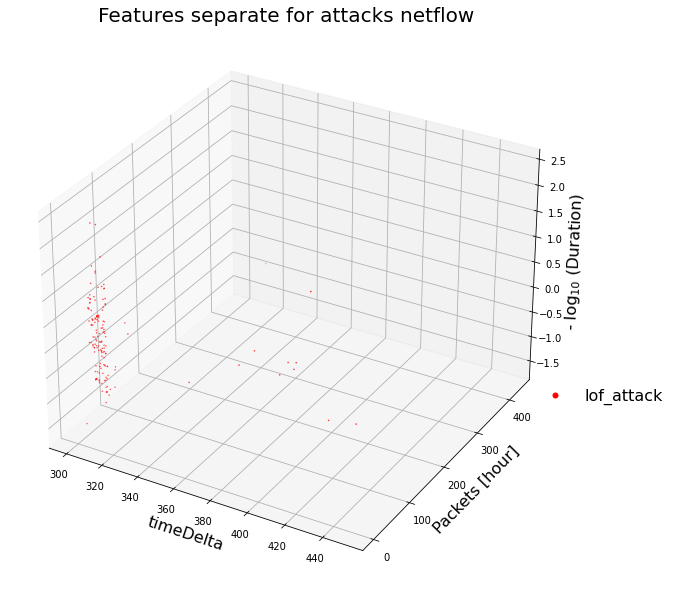

In [ ]:
show3D_netflow_lof_attack_only(lof_results, 'timeDelta', 'Packets', 'Duration')